In [1]:
# !pip install SimpleITK

     |████████████████████████████████| 47.4 MB 206 kB/s eta 0:00:01


# Test SimpleITK read cbct dicom series

In [123]:
import SimpleITK as sitk

reader = sitk.ImageSeriesReader()

dicom_names = reader.GetGDCMSeriesFileNames('data/20201110_CBCT加reg檔案/L224_GYN/20190308_CBCT/')
reader.SetFileNames(dicom_names)


image = reader.Execute()

size = image.GetSize()
print("Image size:", size[0], size[1], size[2])

Image size: 512 512 88


In [124]:
import matplotlib.pyplot as plt

## to numpy
https://officeguide.cc/python-simpleitk-tutorial-read-and-view-image/

In [125]:
# 轉為 NumPy 陣列
nda_copy = sitk.GetArrayFromImage(image) # 深度複製（deep copy）
nda = sitk.GetArrayViewFromImage(image)  # 非深度複製，顯示用


In [126]:
nda_copy.shape

(88, 512, 512)

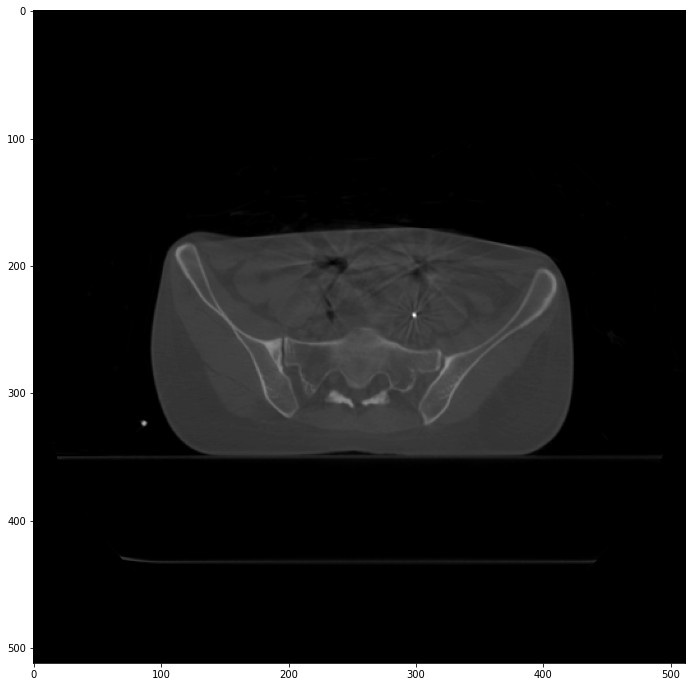

In [128]:
plt.figure(figsize=(12,12))
plt.imshow(nda_copy[70], 'gray')

# read ct dicom series

In [129]:
import SimpleITK as sitk

reader = sitk.ImageSeriesReader()

dicom_names = reader.GetGDCMSeriesFileNames('data/20201110_CBCT加reg檔案/L224_GYN/20190227_CT sim/')
reader.SetFileNames(dicom_names)


image = reader.Execute()

size = image.GetSize()
print("Image size:", size[0], size[1], size[2])

Image size: 512 512 93


In [131]:
# 轉為 NumPy 陣列
nda_copy2 = sitk.GetArrayFromImage(image) # 深度複製（deep copy）


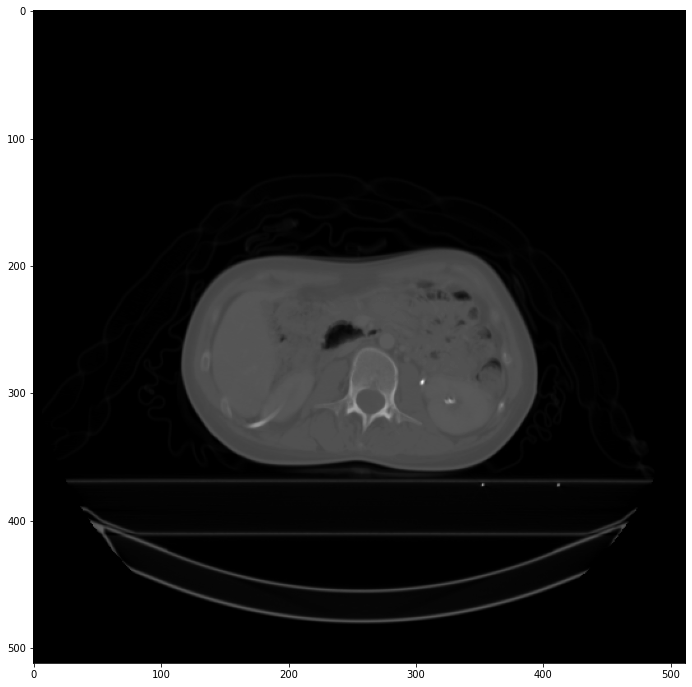

In [139]:
plt.figure(figsize=(12,12))
plt.imshow(nda_copy2[65], 'gray')

# pydicom

In [42]:
import numpy as np
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import os
import glob

import matplotlib.pyplot as plt
%matplotlib inline

In [43]:
def read_dicom(path):
    g = glob.glob(path + '/CT*.dcm')
    slices = [pydicom.read_file(s) for s in g]
    slices.sort(key=lambda x: int(x.InstanceNumber))
    print('RescaleIntercept :{}'.format(slices[0].RescaleIntercept))
    print('RescaleSlope :{}'.format(slices[0].RescaleSlope))
    print('SliceThickness :{}'.format(slices[0].SliceThickness))
    print('Pixel Spacing  :{}'.format(slices[0].PixelSpacing ))

    return slices

In [46]:
slices_cbct = read_dicom('data/20201110_CBCT加reg檔案/L224_GYN/20190308_CBCT')

RescaleIntercept :-1000
RescaleSlope :1
SliceThickness :1.98849010467529
Pixel Spacing  :[9.0802038e-1, 9.0802038e-1]


In [45]:
slices_ct = read_dicom('data/20201110_CBCT加reg檔案/L224_GYN/20190227_CT sim')

RescaleIntercept :-1024
RescaleSlope :1
SliceThickness :5
Pixel Spacing  :[9.765625e-1, 9.765625e-1]


In [85]:
slices_ct[55].pixel_array.dtype

dtype('uint16')

In [97]:
import cv2

In [98]:
2**16

65536

In [99]:
image = cv2.cvtColor(slices_ct[55].pixel_array,cv2.COLOR_GRAY2BGR)

cvuint8 = cv2.convertScaleAbs(image, alpha=(255.0/65535.0))

ct = cv2.cvtColor(cvuint8, cv2.COLOR_BGR2GRAY)

In [103]:
image = cv2.cvtColor(slices_cbct[70].pixel_array,cv2.COLOR_GRAY2BGR)

cvuint8 = cv2.convertScaleAbs(image, alpha=(255.0/65535.0))

cbct = cv2.cvtColor(cvuint8, cv2.COLOR_BGR2GRAY)

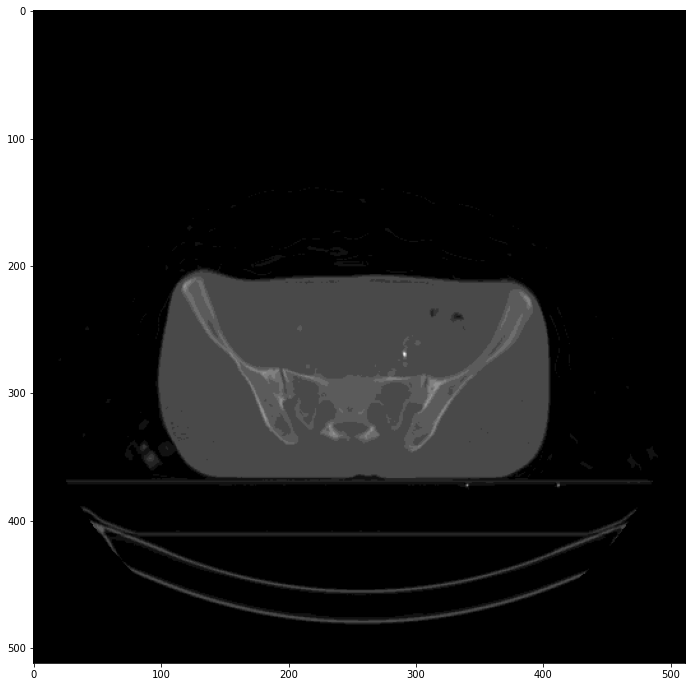

In [104]:
plt.figure(figsize=(12,12))
plt.imshow(ct, 'gray')
plt.show()

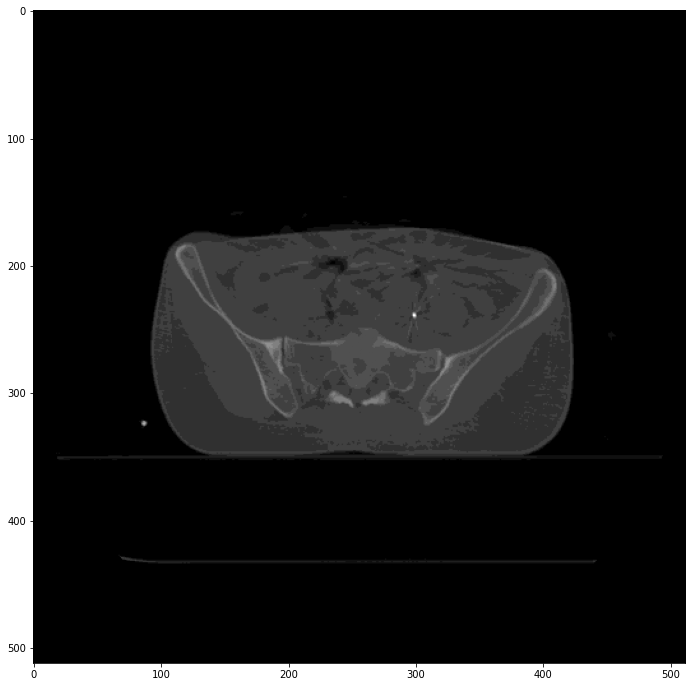

In [105]:
plt.figure(figsize=(12,12))
plt.imshow(cbct, 'gray')
plt.show()

# Registration

In [106]:
fixed = sitk.GetImageFromArray(cbct)
moving = sitk.GetImageFromArray(ct)

R = sitk.ImageRegistrationMethod()
R.SetMetricAsMeanSquares()
R.SetOptimizerAsRegularStepGradientDescent(4.0, .01, 200)
R.SetInitialTransform(sitk.TranslationTransform(fixed.GetDimension()))
R.SetInterpolator(sitk.sitkLinear)

R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R))

outTx = R.Execute(fixed, moving)

print("-------")
print(outTx)
print(f"Optimizer stop condition: {R.GetOptimizerStopConditionDescription()}")
print(f" Iteration: {R.GetOptimizerIteration()}")
print(f" Metric value: {R.GetMetricValue()}")

sitk.WriteTransform(outTx, sys.argv[3])

if ("SITK_NOSHOW" not in os.environ):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(fixed)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(100)
    resampler.SetTransform(outTx)

    out = resampler.Execute(moving)
    simg1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
    simg2 = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)
    cimg = sitk.Compose(simg1, simg2, simg1 // 2. + simg2 // 2.)
    sitk.Show(cimg, "ImageRegistration1 Composition")

RuntimeError: Exception thrown in SimpleITK ImageRegistrationMethod_Execute: /tmp/SimpleITK/Code/Registration/src/sitkImageRegistrationMethod.cxx:781:
sitk::ERROR: Filter does not support fixed image type: 8-bit unsigned integer